# Example 2: Cepstral Analysis of liquid NaCl
This example shows the basic usage of *thermocepstrum* to compute the thermal conductivity of a classical MD simulation of molten NaCl, which requires the **multi-component** theory.

In [5]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
try:
    import thermocepstrum as tc
except ImportError:
    from sys import path
    path.append('..')
    import thermocepstrum as tc

c = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [6]:
%matplotlib notebook

## 1. Load trajectory
Read the heat current from a simple column-formatted file. The desired columns are selected based on their header (e.g. with LAMMPS format).

For other input formats see the corresponding example.

In [7]:
jfile = tc.i_o.TableFile('./data/NaCl.dat', group_vectors=True)

Temp    c_flux[1] c_flux[2] c_flux[3] c_vcm[1][1] c_vcm[1][2] c_vcm[1][3]
 #####################################
  all_ckeys =  {'Temp': [0], 'flux': array([1, 2, 3]), 'vcm[1]': array([4, 5, 6])}
 #####################################
Data length =  20000


We need to load the energy flux (`flux`) and one mass flux (`vcm[1]`, that is the velocity of the center of mass of one species).

In [8]:
jfile.read_datalines(start_step=0, NSTEPS=0, select_ckeys=['Temp', 'flux', 'vcm[1]'])

  ckey =  {'Temp': [0], 'flux': array([1, 2, 3]), 'vcm[1]': array([4, 5, 6])}
  ( 20000 ) steps read.
DONE.  Elapsed time:  0.276231050491333 seconds


{'Temp': array([[1442.7319],
        [1440.806 ],
        [1440.6008],
        ...,
        [1402.7391],
        [1392.6822],
        [1385.4031]]),
 'flux': array([[ 250.86549   ,   20.619423  ,  200.115     ],
        [ 196.22265   ,   82.667342  ,  284.3325    ],
        [ 126.39441   ,  160.75472   ,  340.36769   ],
        ...,
        [ 179.91856   ,   18.612706  , -132.65623   ],
        [ 204.71193   ,   -0.46643315, -204.0165    ],
        [ 241.23318   ,  -18.295461  , -252.46475   ]]),
 'vcm[1]': array([[-0.15991832, -0.07137043,  0.02068792],
        [-0.13755206, -0.07100293, -0.01127988],
        [-0.10615044, -0.06238124, -0.04156812],
        ...,
        [-0.0919399 , -0.08477829,  0.06001139],
        [-0.13384949, -0.1147453 ,  0.08932355],
        [-0.18385053, -0.1369343 ,  0.1143406 ]])}

## 2. Heat Current
Define a **HeatCurrent** from the trajectory, with the correct parameters. The difference with respect to the single-component case is only here: we load a list of currents instead of a single one.

In [9]:
DT_FS = 5.0           # time step [fs]
TEMPERATURE = np.mean(jfile.data['Temp'])   # temperature [K]
VOLUME = 40.21**3     # volume [A^3]
print ('T = {:f} K'.format(TEMPERATURE))
print ('V = {:f} A^3'.format(VOLUME))

j = tc.HeatCurrent([jfile.data['flux'], jfile.data['vcm[1]']], 'metal', DT_FS, TEMPERATURE, VOLUME)

T = 1399.347781 K
V = 65013.301261 A^3
Using multicomponent code.


<IPython.core.display.Javascript object>


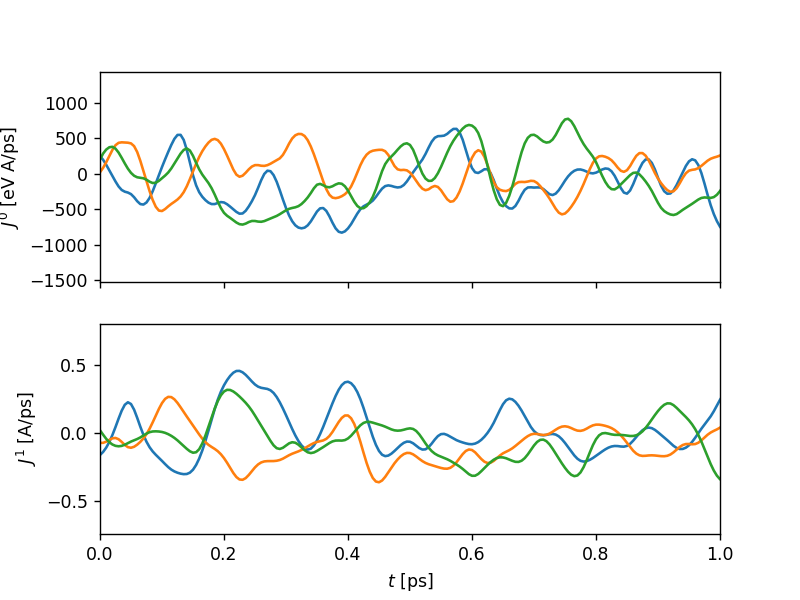

In [10]:
# trajectory
f, ax = plt.subplots(2, sharex=True)
ax[0].plot(j.timeseries()/1000., j.traj);
ax[1].plot(j.timeseries()/1000., j.otherMD[0].traj);
plt.xlim([0, 1.0])
plt.xlabel(r'$t$ [ps]')
ax[0].set_ylabel(r'$J^0$ [eV A/ps]');
ax[1].set_ylabel(r'$J^1$ [A/ps]');

Compute the **Reduced periodogram** $\bar{\mathcal{S}}^0_k$ and filter it for visualization. You can notice the difference with respect to the energ-flux periodogram $\mathcal{S}^0_k$.

<IPython.core.display.Javascript object>


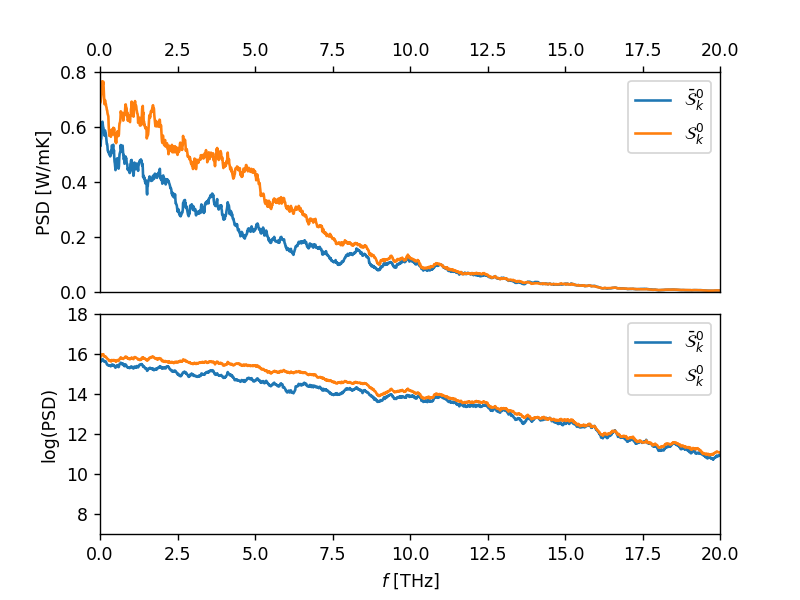

100.0


In [11]:
# Periodogram with given filtering window width
ax = j.plot_periodogram(PSD_FILTER_W=0.4, kappa_units=True, label=r'$\bar{\mathcal{S}}^0_k$')
print (j.Nyquist_f_THz)

# compare with the spectrum of the energy flux
jen = tc.HeatCurrent(jfile.data['flux'], 'metal', DT_FS, TEMPERATURE, VOLUME)
ax = jen.plot_periodogram(axes=ax, PSD_FILTER_W=0.4, kappa_units=True, label=r'$\mathcal{S}^0_k$')
plt.xlim([0, 20])
ax[0].set_ylim([0, 0.8]);
ax[1].set_ylim([7, 18]);
ax[0].legend(); ax[1].legend();

## 3. Resampling
If the Nyquist frequency is very high (i.e. the sampling time is small), such that the log-spectrum goes to low values, you may want resample your time series to obtain a maximum frequency $f^*$.
Before performing that operation, the time series is automatically filtered to reduce the amount of aliasing introduced. Ideally you do not want to go too low in $f^*$. In an intermediate region the results should not change. 

To perform resampling you can choose the resampling frequency $f^*$ or the resampling step (`TSKIP`). If you choose $f^*$, the code will try to choose the closest value allowed.
The resulting PSD is visualized to ensure that the low-frequency region is not affected. 

<IPython.core.display.Javascript object>


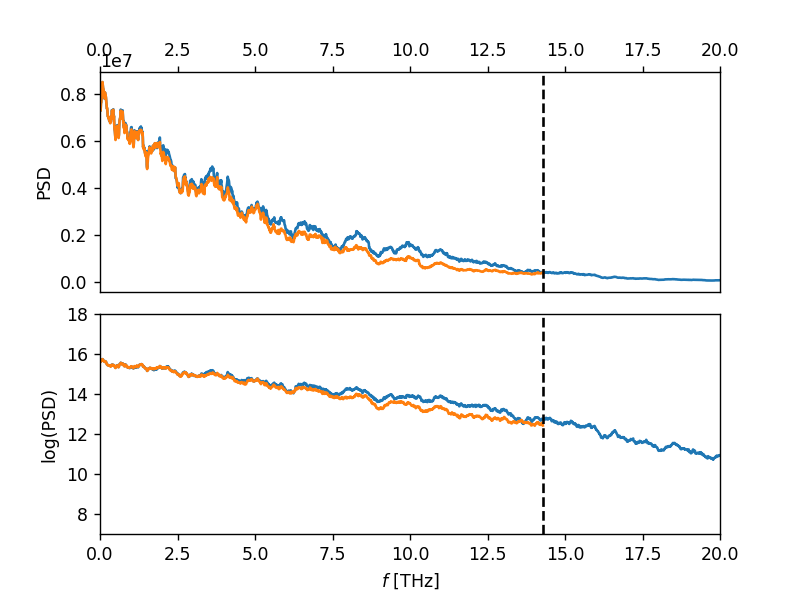

Using multicomponent code.
-----------------------------------------------------
  RESAMPLE TIME SERIES
-----------------------------------------------------
 Original Nyquist freq  f_Ny =     100.00000 THz
 Resampling freq          f* =      14.28571 THz
 Sampling time         TSKIP =             7 steps
                             =        35.000 fs
 Original  n. of frequencies =         10001
 Resampled n. of frequencies =          1429
 PSD      @cutoff  (pre-filter) = 392810.55342
                  (post-filter) = 367183.46153
 log(PSD) @cutoff  (pre-filter) =     12.70308
                  (post-filter) =     12.42357
 min(PSD)          (pre-filter) =      0.31536
 min(PSD)         (post-filter) =  22166.11934
 % of original PSD Power f<f* (pre-filter)  = 96.678574
-----------------------------------------------------



In [12]:
FSTAR_THZ = 14.0
jf, ax = tc.heatcurrent.resample_current(j, fstar_THz=FSTAR_THZ, plot=True, freq_units='thz')
plt.xlim([0, 20])
ax[1].set_ylim([7, 18]);

<IPython.core.display.Javascript object>


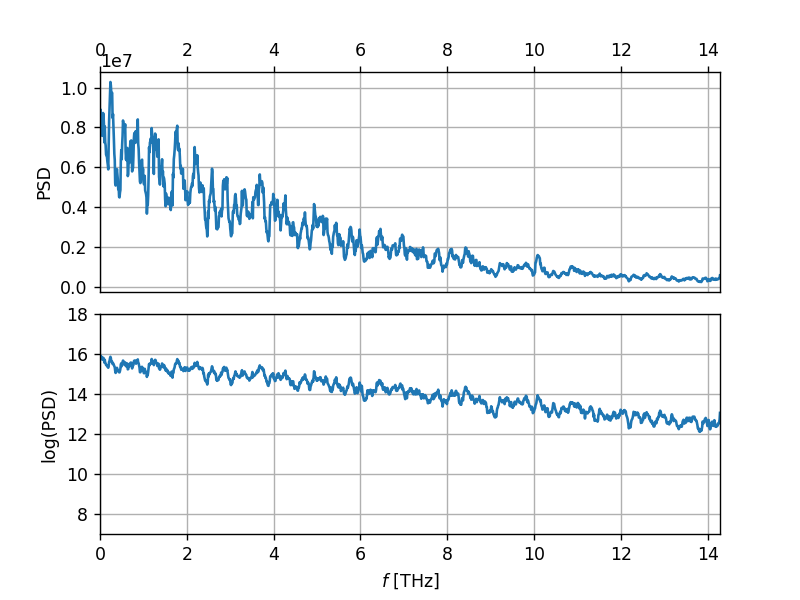

In [13]:
ax = jf.plot_periodogram(PSD_FILTER_W=0.1)
ax[1].set_ylim([7, 18]);

## 4. Cepstral Analysis
Perform Cepstral Analysis. The code will:
 1. the parameters describing the theoretical distribution of the PSD are computed
 2. the Cepstral coefficients are computed by Fourier transforming the log(PSD)
 3. the Akaike Information Criterion is applied
 4. the resulting $\kappa$ is returned

In [14]:
jf.cepstral_analysis()

-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 3  (P* = 4, corr_factor = 1.000000)
  L_0*   =          15.158757 +/-   0.056227
  S_0*   =     6824108.702608 +/- 383697.095268
-----------------------------------------------------
  kappa* =           0.498310 +/-   0.028018  W/mK
-----------------------------------------------------



c_k =  [ 1.43138519e+01  6.58383813e-01 -6.48049965e-03 ...  4.76081379e-03
  2.28241054e-02  3.95167451e-02]


<IPython.core.display.Javascript object>


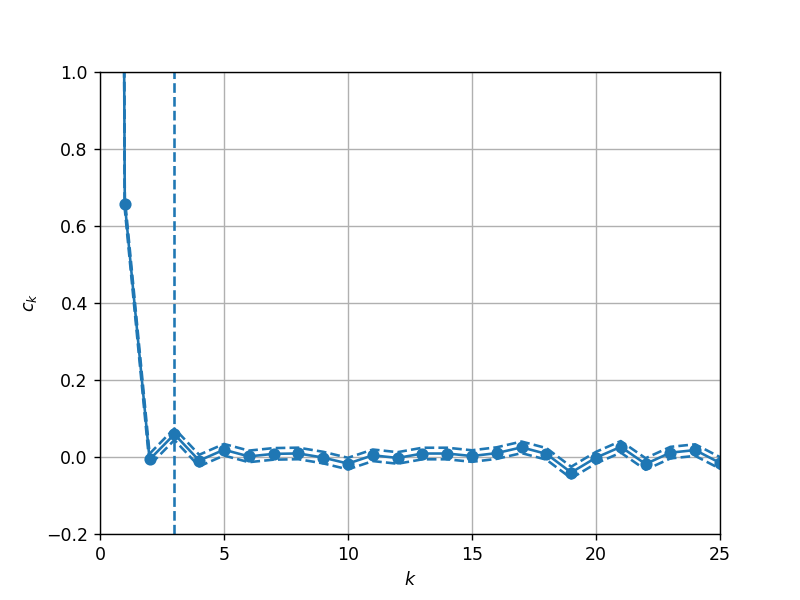

In [15]:
# Cepstral Coefficients
print ('c_k = ', jf.dct.logpsdK)

ax = jf.plot_ck()
ax.set_xlim([0, 25])
ax.set_ylim([-0.2, 1.0])
ax.grid();

<IPython.core.display.Javascript object>


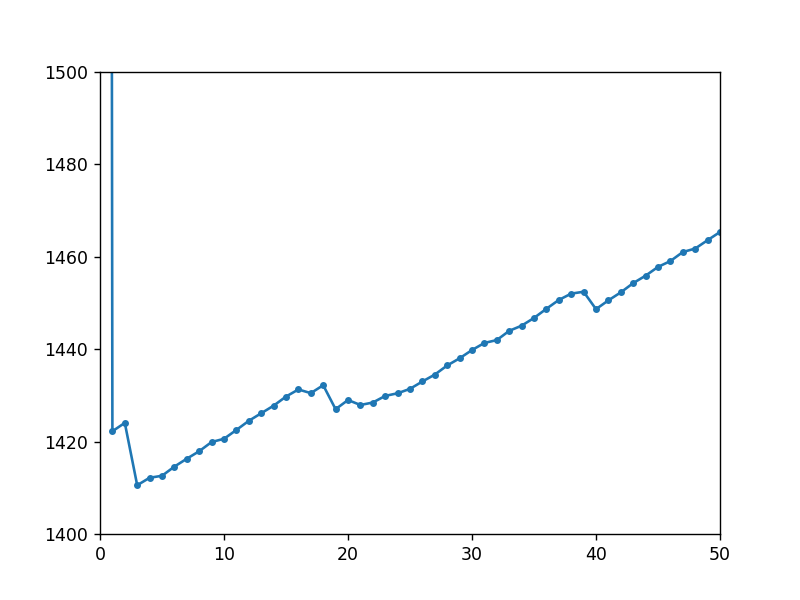

K of AIC_min = 3
AIC_min = 1410.555757


In [16]:
# AIC function
f = plt.figure()
plt.plot(jf.dct.aic, '.-', c=c[0])
plt.xlim([0, 50])
plt.ylim([1400, 1500]);

print ('K of AIC_min = {:d}'.format(jf.dct.aic_Kmin))
print ('AIC_min = {:f}'.format(jf.dct.aic_min))

Plot the thermal conductivity $\kappa$ as a function of the cutoff $P^*$

<IPython.core.display.Javascript object>


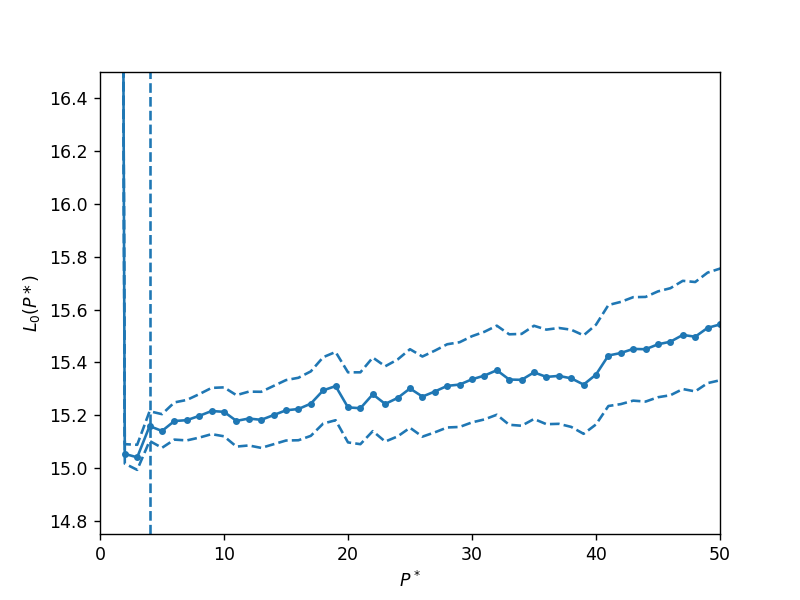

K of AIC_min = 3
AIC_min = 1410.555757


In [17]:
# L_0 as a function of cutoff K
ax = jf.plot_L0_Pstar()
ax.set_xlim([0, 50])
ax.set_ylim([14.75, 16.5]);

print ('K of AIC_min = {:d}'.format(jf.dct.aic_Kmin))
print ('AIC_min = {:f}'.format(jf.dct.aic_min))

<IPython.core.display.Javascript object>


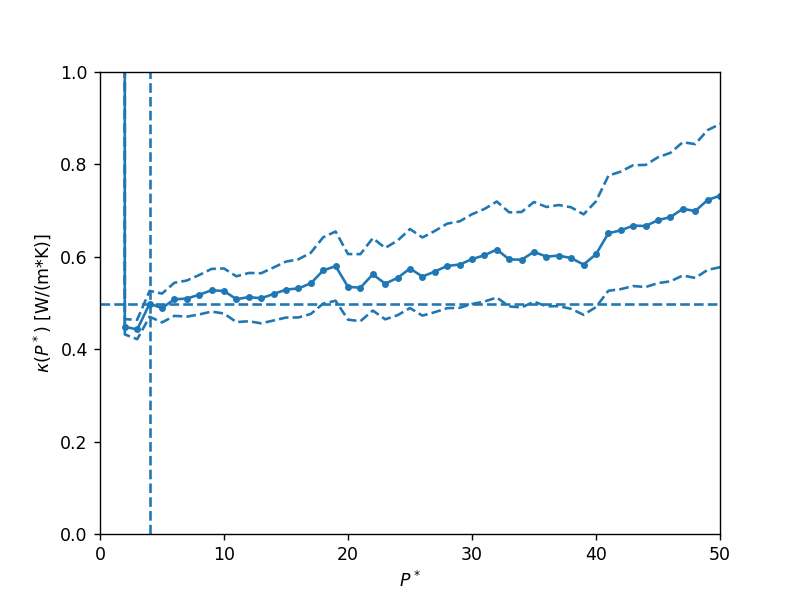

K of AIC_min = 3
AIC_min = 1410.555757


In [18]:
# kappa as a function of cutoff K
ax = jf.plot_kappa_Pstar()
ax.set_xlim([0, 50])
ax.set_ylim([0, 1.0]);

print ('K of AIC_min = {:d}'.format(jf.dct.aic_Kmin))
print ('AIC_min = {:f}'.format(jf.dct.aic_min))

Print the results :)

In [19]:
print (jf.cepstral_log)

-----------------------------------------------------
  CEPSTRAL ANALYSIS
-----------------------------------------------------
  AIC_Kmin  = 3  (P* = 4, corr_factor = 1.000000)
  L_0*   =          15.158757 +/-   0.056227
  S_0*   =     6824108.702608 +/- 383697.095268
-----------------------------------------------------
  kappa* =           0.498310 +/-   0.028018  W/mK
-----------------------------------------------------



You can now visualize the filtered PSD...

<IPython.core.display.Javascript object>


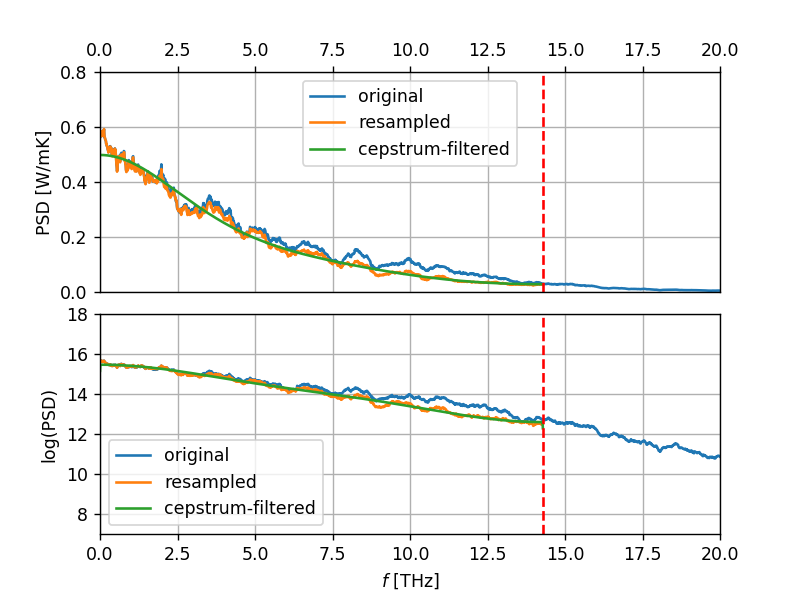

In [20]:
# filtered log-PSD
ax = j.plot_periodogram(0.5, kappa_units=True)
ax = jf.plot_periodogram(0.5, axes=ax, kappa_units=True)
ax = jf.plot_cepstral_spectrum(axes=ax, kappa_units=True)
ax[0].axvline(x = jf.Nyquist_f_THz, ls='--', c='r')
ax[1].axvline(x = jf.Nyquist_f_THz, ls='--', c='r')
plt.xlim([0, 20])
ax[0].set_ylim([0, 0.8]);
ax[1].set_ylim([7, 18]);
ax[0].legend(['original', 'resampled', 'cepstrum-filtered'])
ax[1].legend(['original', 'resampled', 'cepstrum-filtered']);